# Dataset shift

**Background**

In the previous assignment you have worked with wafer map data from a semiconductor manufacturing process, and developed a calibrated binary classifier for identifying whether a finished wafer contains a known pattern of faulty chips.

Imagine the company has evaluated several classifiers and deployed one of them in production, as part of a larger system for identifying the root causes of faulty chips. The root cause analysis relies on the expertise of human operators. When the root cause of faulty chips on a wafer can be identified, the process parameters can be adjusted, reducing the number of faulty chips and increasing wafer yield.

Ideally, the company would like all wafers to be analyzed by the operators, however, their capacity is limited. Therefore, the classifier is used as part of a filtering stage to select wafers for further analysis by the operators, based on whether the wafers contain a known pattern of faulty chips.

One month after deploying the classifier, the company observes degrading wafer yield. They think it is due to a drop in classification performance of the classifier: misclassifying wafers that are suitable for further analysis will prevent the operators from identifying the root causes of faulty chips and adapting the process parameters, resulting in more faults and lower yield. They suspect it may be related to a recent change of a process parameter at one of the manufacturing stages.

**Assignment**

You are given three datasets:
- a labeled *training* set that represents the data used to train the classifier,
- a partially labeled *production* set representing the data collected after the model was deployed in production.
- an unlabeled *leaderboard* set representing the data collected after the *production* set.

All datasets are based on the WM-811K dataset containing annotated wafer maps collected from real-world fabrication (see `./data/readme.txt`).

You are also given the implementation of the deployed classifier.

Your task is to check if a distribution shift may have caused the deployed classifier to drop in predictive performance, and to improve the predictive performance of the classifier.

Throughout this notebook you will find cells starting with `# // BEGIN_TODO` and `# // END_TODO` tags.

- Fill in all your code between these `# // BEGIN_TODO` and `# // END_TODO` tags.
- Do not edit these tags in any way, or else your answers may not be processed by the grading system.
- You can add as many code and text cells as you want between the `# // BEGIN_TODO` and `# // END_TODO` tags to make your code nicely readable.
- You are free to use any libraries listed in the Hints section on Canvas, but make sure you import all your libraries between the `# // BEGIN_TODO` and `# // END_TODO` tags.

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, but remember:
<br/><br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Only the code in your answer cells (i.e. between `# // BEGIN_TODO` and `# // END_TODO`) will be extracted and evaluated.
</div>

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.
</div>

Let's get started by filling in your details in the following answer cell. Assign your group number, your names and student ids to variables `group_number`, `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [AUTHOR]
group_number = 7
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [AUTHOR]
```

In [1]:
#// BEGIN_TODO [AUTHOR]
group_number = 24
name_student1 = "Mert Gursu Gokcen"
id_student1 = "1924850"
name_student2 = "Devansh Mishra"
id_student2 = "1932551"
#// END_TODO [AUTHOR]

## Import libraries

You are free to use any libraries listed in the Hints section on Canvas, but make sure you import all your libraries between the `# // BEGIN_TODO` and `# // END_TODO` tags below.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, json

import random
random.seed(42)
np.random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load the data

The training data, that was used to train the classifier before deployment, resides in the `./data/wafer_training.pkl` pickle file.

In [3]:
with open('./data/wafer_training.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)

`X_train` contains the wafer maps and `y_train` contains the labels. The maps are 26x26 pixels, a pixel of value 0 represents the background, a pixel of value 1 indicates a good chip, and a pixel of value 2 indicates a bad chip. An example of a wafer map is shown below.

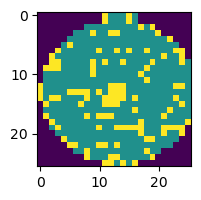

In [4]:
fig, axes = plt.subplots(1, figsize = (2,2))
plt.imshow(X_train[0]);

The production data, that was collected after the classifier was deployed in production, resides in the `./data/wafer_production.pkl` pickle file.

In [5]:
with open('./data/wafer_production.pkl', 'rb') as f:
    X_production, y_production = pickle.load(f)

`X_production` contains the wafer maps and `y_production` contains the labels. The samples are listed in the same order as they were collected.

The wafer maps were labeled by human experts according to whether the wafer map contains a known bad chip pattern or not:

- 1: a pattern (one of the 8 patterns in the Calibration assignment)
- 0: no pattern
- -1: unlabeled sample

You will observe that `y_production` is only partially labeled, i.e. some samples are unlabeled. You can imagine that labeling is time consuming and expensive process and only a subset was labeled, e.g. for monitoring the performance of the classifier.

An example of the wafer map with and without known pattern is shown below.

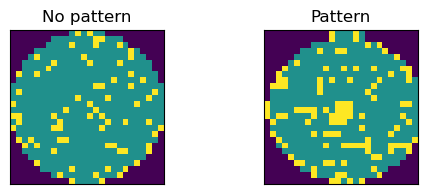

In [6]:
unique_classes, class_indexes = np.unique(y_train,return_index=True)
class_names = ["No pattern", "Pattern"]
fig, axes = plt.subplots(1,2, figsize = (6,2))
for num_index, index in enumerate(class_indexes):
    axes[num_index].imshow(X_train[index])
    axes[num_index].set_title(class_names[unique_classes[num_index]])
    axes[num_index].set_xticks([])
    axes[num_index].set_yticks([])

## Define the classifier

Here is the implementation of the deployed classifier for identifying whether a finished wafer contains a known pattern of faulty chips. It is a random forest classifier, initialized with `random_state=42` for reproducibility.

In [7]:
from sklearn.ensemble import RandomForestClassifier

deployed_classifier = RandomForestClassifier(random_state=42)

## Detect distribution shift

The company suspects there is a distribution shift in the `./data/wafer_production.pkl`. Verify this suspicion by identifying at which point in the production a shift (if any) has occured.

Assign to the integer variable `distribution_shift_index` the index in the production data where a shift has occured, or `None` if a shift has not occured.

Assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score. If you do not wat to participate on the leaderboard, set it to `None`.

In [8]:
print("Training Data Shape:", X_train.shape)
print("Production Data Shape:", X_production.shape)

Training Data Shape: (4969, 26, 26)
Production Data Shape: (10311, 26, 26)


In [9]:
print(np.unique(y_train))
print(np.unique(y_production)) #A new label is introduced!!--> Label schema change

[0 1]
[-1  0  1]


In [10]:
unique_values, counts = np.unique(y_train, return_counts=True)
print(unique_values, counts)

unique_values_p, counts_p = np.unique(y_production, return_counts=True)
print(unique_values_p, counts_p)
#IDEA: TO improve, -1 values can be dropped and then predicted and 
#then used as if they were labeled that way and then check how the model performs

[0 1] [3497 1472]
[-1  0  1] [6874 2404 1033]


In [11]:
#// BEGIN_TODO [SHIFT_DETECTION]
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp

X_train_reshaped = X_train.reshape((len(X_train), -1))

deployed_classifier.fit(X_train_reshaped, y_train)

X_production_reshaped = X_production.reshape((len(X_production), -1))

y_production_pred = deployed_classifier.predict(X_production_reshaped)

production_accuracy = accuracy_score(y_production, y_production_pred)

def detect_distribution_shift(data1, data2):
    shifts = []
    for i in range(data1.shape[1]):
        statistic, p_value = ks_2samp(data1[:, i], data2[:, i])
        if statistic > 0.1 and p_value < 0.1e-10:
            return i

def findLabelSchemaChange(y):
    for index, label in enumerate(y):
        if label == -1:
            return index

distribution_shift_index = findLabelSchemaChange(y_production)
leaderboard_nickname = "Group24"

print("Production Accuracy:", production_accuracy)
print("Distribution Shift Index:", distribution_shift_index)



Production Accuracy: 0.26990592571040634
Distribution Shift Index: 0


In [12]:
#// END_TODO [SHIFT_DETECTION]

Run the following cell to create a file with your leaderboard submission.

In [13]:
if leaderboard_nickname is not None:
    
    # perform some sanity checks
    assert isinstance(group_number, int), "group_number is not an integer"
    assert isinstance(leaderboard_nickname, str), "leaderboard_nickname is not a string"
    assert isinstance(distribution_shift_index, int), "distribution_shift_index is not an integer"

    # export the solution to a .json file
    with open("leaderboard_detection.json", "w") as file:
        json.dump({
            "group_number": group_number,
            "leaderboard_nickname": leaderboard_nickname,
            "distribution_shift_index": distribution_shift_index
        }, file)

If all went well, a `leaderboard_detection.json` file should have been created in the same directory as this notebook.

## Improve the predictive perfromance using any classifier

Improve the F1 score of identifying whether a wafer contains a known faulty chip pattern or not relative to the `deployed_classifer` trained on the training set: 

In [14]:
deployed_classifier.fit(X_train.reshape(-1, 26*26), y_train);

You are free to use any classifier you like, including the `deployed_classifier`. The performance of the improved classifier will be evaluated on unlabeld data inside `./data/wafer_leaderboard.pkl`.

In [15]:
with open('./data/wafer_leaderboard.pkl', 'rb') as f:
    X_leaderboard = pickle.load(f)

Use your improved classifier to you predict the labels for samples in `X_leaderboard`. Assign the predictions to variable `y_improved_classifier`. The variable `y_deployed_classifier` should be an `np.ndarray` with the same number of elements as `X_leaderboard`, and the predicted labels should follow the order corresponding to the samples in `X_leaderboard`.

Assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score. If you do not wat to participate on the leaderboard, set it to `None`.

In [16]:
#// BEGIN_TODO [PREDICTION]

y_improved_classifier = deployed_classifier.predict(X_leaderboard.reshape(-1, 26*26))

# ===== =====> Replace this line by your code. <===== ===== #


In [17]:
#// END_TODO [PREDICTION]

Run the following cell to create a file with your leaderboard submission.

In [18]:
if leaderboard_nickname is not None:
    
    # perform some sanity checks
    assert isinstance(group_number, int), "group_number is not an integer"
    assert isinstance(leaderboard_nickname, str), "leaderboard_nickname is not a string"
    assert isinstance(y_improved_classifier, np.ndarray), "y_improved_classifier is not an np.ndarray"
    assert y_improved_classifier.shape[0] == X_leaderboard.shape[0], "y_improved_classifier has wrong shape"
    assert y_improved_classifier.ndim == 1, "y_improved_classifier is not an 1d-array"

    # export the solution to a .json file
    with open("leaderboard_prediction.json", "w") as file:
        json.dump({
            "group_number": group_number,
            "leaderboard_nickname": leaderboard_nickname,
            "y_improved_classifier": y_improved_classifier.tolist()
        }, file)

If all went well, a `leaderboard_prediction.json` file should have been created in the same directory as this notebook.

# Feedback

Please fill in this questionaire to help us improve this course for the next year. **Your feedback will be anonymized and will not affect your grade in any way!**

### How many hours did you spend on this assignment?

Assign a number to variable `feedback_time`.

In [19]:
#// BEGIN_FEEDBACK [Feedback_1] (0 points)

#// END_FEEDBACK [Feedback_1]
feedback_time = 5
import numbers
assert isinstance(feedback_time, numbers.Number), "Please assign a number to variable feedback_time"

### How difficult did you find this assignment?

Assign an integer to variable `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [20]:
#// BEGIN_FEEDBACK [Feedback_2] (0 points)
feedback_difficulty = 7
#// END_FEEDBACK [Feedback_2]

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to variable feedback_difficulty"

### Did you use a Large Language Model (LLM) to help you with this and/or the Calibration assignment? If so, how were they useful?

We are curious to learn how LLMs are used for study, so that we can adapt what and how we teach.

Assign a string to variable `feedback_llm` describing how you used LLMs for solving the assignments (e.g. you can name several useful prompts), and any insights you may like to share. If you did not use an LLM, assign `None` to `feedback_llm`.

In [21]:
#// BEGIN_FEEDBACK [Feedback_3] (0 points)

#// END_FEEDBACK [Feedback_3]

### (Optional) What did you like?

Assign a string to variable `feedback_like`.

In [22]:
#// BEGIN_FEEDBACK [Feedback_4] (0 points)

#// END_FEEDBACK [Feedback_4]

### (Optional) What can be improved?

Assign a string to variable `feedback_improve`. Please be specific, so that we can act on your feedback.

In [23]:
#// BEGIN_FEEDBACK [Feedback_5] (0 points)

#// END_FEEDBACK [Feedback_5]